In [1]:
%run Global.ipynb
%run Helper_Functions.ipynb

In [2]:
train_df_ohe_selected = pd.read_csv(DATASET_DIR + "/train_df_ohe_selected_50.csv", keep_default_na=False)

X = train_df_ohe_selected.iloc[:,:-1] # (transformed) attributes
y = train_df_ohe_selected.iloc[:,-1]  # ground truth labels

In [3]:
# run in terminal: python -m pip install mlxtend
# https://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/#example-3-stacked-cv-classification-and-gridsearch
import mlxtend
from mlxtend.classifier import StackingCVClassifier

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm

gnb = GaussianNB()  # gaussian NB
linearSVM = svm.LinearSVC(random_state=30027, C=1)  # linear svm
logr = LogisticRegression(solver='sag', max_iter=100)  # logr
dt = DecisionTreeClassifier(max_depth = 200, random_state = 30027)  # decision tree
knn = KNeighborsClassifier(n_neighbors=1)  # knn

In [5]:
sclf = StackingCVClassifier(classifiers=[gnb, linearSVM, logr, dt, knn], 
                            meta_classifier=LogisticRegression(),
                            cv = 2,
                            random_state=30027)

In [6]:
sclf.get_params()

{'classifiers': [GaussianNB(),
  LinearSVC(C=1, random_state=30027),
  LogisticRegression(solver='sag'),
  DecisionTreeClassifier(max_depth=200, random_state=30027),
  KNeighborsClassifier(n_neighbors=1)],
 'cv': 2,
 'drop_proba_col': None,
 'meta_classifier__C': 1.0,
 'meta_classifier__class_weight': None,
 'meta_classifier__dual': False,
 'meta_classifier__fit_intercept': True,
 'meta_classifier__intercept_scaling': 1,
 'meta_classifier__l1_ratio': None,
 'meta_classifier__max_iter': 100,
 'meta_classifier__multi_class': 'auto',
 'meta_classifier__n_jobs': None,
 'meta_classifier__penalty': 'l2',
 'meta_classifier__random_state': None,
 'meta_classifier__solver': 'lbfgs',
 'meta_classifier__tol': 0.0001,
 'meta_classifier__verbose': 0,
 'meta_classifier__warm_start': False,
 'meta_classifier': LogisticRegression(),
 'n_jobs': None,
 'pre_dispatch': '2*n_jobs',
 'random_state': 30027,
 'shuffle': True,
 'store_train_meta_features': False,
 'stratify': True,
 'use_clones': True,
 'use_

In [7]:
param_grid = {'linearsvc__C': range(1,11,5), 
              'decisiontreeclassifier__max_depth': range(200, 401, 50), 
              'kneighborsclassifier__n_neighbors': range(1,6)}

grid = tune_hyperparameter(sclf, param_grid, X, y, cv=2)

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[CV] END decisiontreeclassifier__max_depth=200, kneighborsclassifier__n_neighbors=1, linearsvc__C=1; total time=  22.3s
[CV] END decisiontreeclassifier__max_depth=200, kneighborsclassifier__n_neighbors=1, linearsvc__C=1; total time=  22.3s
[CV] END decisiontreeclassifier__max_depth=200, kneighborsclassifier__n_neighbors=1, linearsvc__C=6; total time=  22.7s
[CV] END decisiontreeclassifier__max_depth=200, kneighborsclassifier__n_neighbors=1, linearsvc__C=6; total time=  22.5s
[CV] END decisiontreeclassifier__max_depth=200, kneighborsclassifier__n_neighbors=2, linearsvc__C=1; total time=  22.7s
[CV] END decisiontreeclassifier__max_depth=200, kneighborsclassifier__n_neighbors=2, linearsvc__C=1; total time=  22.7s
[CV] END decisiontreeclassifier__max_depth=200, kneighborsclassifier__n_neighbors=2, linearsvc__C=6; total time=  22.5s
[CV] END decisiontreeclassifier__max_depth=200, kneighborsclassifier__n_neighbors=2, linearsvc__C=

[CV] END decisiontreeclassifier__max_depth=350, kneighborsclassifier__n_neighbors=3, linearsvc__C=1; total time=  22.8s
[CV] END decisiontreeclassifier__max_depth=350, kneighborsclassifier__n_neighbors=3, linearsvc__C=1; total time=  22.9s
[CV] END decisiontreeclassifier__max_depth=350, kneighborsclassifier__n_neighbors=3, linearsvc__C=6; total time=  22.9s
[CV] END decisiontreeclassifier__max_depth=350, kneighborsclassifier__n_neighbors=3, linearsvc__C=6; total time=  23.1s
[CV] END decisiontreeclassifier__max_depth=350, kneighborsclassifier__n_neighbors=4, linearsvc__C=1; total time=  22.7s
[CV] END decisiontreeclassifier__max_depth=350, kneighborsclassifier__n_neighbors=4, linearsvc__C=1; total time=  22.7s
[CV] END decisiontreeclassifier__max_depth=350, kneighborsclassifier__n_neighbors=4, linearsvc__C=6; total time=  22.8s
[CV] END decisiontreeclassifier__max_depth=350, kneighborsclassifier__n_neighbors=4, linearsvc__C=6; total time=  23.1s
[CV] END decisiontreeclassifier__max_dep

In [8]:
r = re.compile('(^(rank_test).*(f1-score|accuracy)$)|(mean_test_accuracy)|(params)')
score_metrics = list(filter(r.match, grid.columns))
grid.loc[grid['rank_test_5.0_precision'] < 20][score_metrics]
# all except for 1 hyperparameter assignments give 5.0 f1 score = 0 hence all rated second

,params,rank_test_3.0_f1-score,rank_test_4.0_f1-score,rank_test_5.0_f1-score,mean_test_accuracy,rank_test_accuracy
0,"{'decisiontreeclassifier__max_depth': 200, 'kn...",16,17,3,0.726488,17
1,"{'decisiontreeclassifier__max_depth': 200, 'kn...",19,25,3,0.725708,25
2,"{'decisiontreeclassifier__max_depth': 200, 'kn...",2,7,3,0.728179,5
3,"{'decisiontreeclassifier__max_depth': 200, 'kn...",48,42,3,0.724841,46
4,"{'decisiontreeclassifier__max_depth': 200, 'kn...",10,4,3,0.728223,3
5,"{'decisiontreeclassifier__max_depth': 200, 'kn...",33,49,3,0.724884,44
6,"{'decisiontreeclassifier__max_depth': 200, 'kn...",3,11,3,0.728093,8
7,"{'decisiontreeclassifier__max_depth': 200, 'kn...",36,38,3,0.725058,35
8,"{'decisiontreeclassifier__max_depth': 200, 'kn...",24,24,3,0.725968,23
9,"{'decisiontreeclassifier__max_depth': 200, 'kn...",32,32,3,0.725274,31


In [9]:
grid.loc[grid['rank_test_5.0_precision'] == 1]['params'].values

array([{'decisiontreeclassifier__max_depth': 400, 'kneighborsclassifier__n_neighbors': 1, 'linearsvc__C': 1}],
      dtype=object)

In [10]:
print(max(grid['mean_test_accuracy']))
grid.loc[grid['mean_test_accuracy'] == max(grid['mean_test_accuracy'])]['params'].values

0.7284828132089183


array([{'decisiontreeclassifier__max_depth': 350, 'kneighborsclassifier__n_neighbors': 1, 'linearsvc__C': 1}],
      dtype=object)

In [11]:
# gaussian NB
gnb = GaussianNB()

# linear svm
linearSVM = svm.LinearSVC(random_state=30027, C=1)

# logr
logr = LogisticRegression(solver='sag', max_iter=100)

# decision tree
dt = DecisionTreeClassifier(max_depth = 400, random_state = 30027)

# knn
knn = KNeighborsClassifier(n_neighbors=3)

sclf = StackingCVClassifier(classifiers=[gnb, linearSVM, logr, dt, knn], 
                            meta_classifier=LogisticRegression(),
                            cv = 2,
                            random_state=30027)


StackingCVClassifier prediction took 404.1753890514374 seconds
   test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0           0.350195           0.841037           0.000000       0.740789
1           0.306864           0.838196           0.039604       0.735154
2           0.295580           0.840327           0.019802       0.736888
3           0.275000           0.836277           0.000000       0.730703
4           0.326087           0.842468           0.000000       0.741977
5           0.285714           0.834483           0.000000       0.728101
6           0.263083           0.837014           0.000000       0.730703
7           0.290859           0.839578           0.000000       0.735473
8           0.310391           0.838282           0.000000       0.735473
9           0.279391           0.837909           0.019802       0.732437


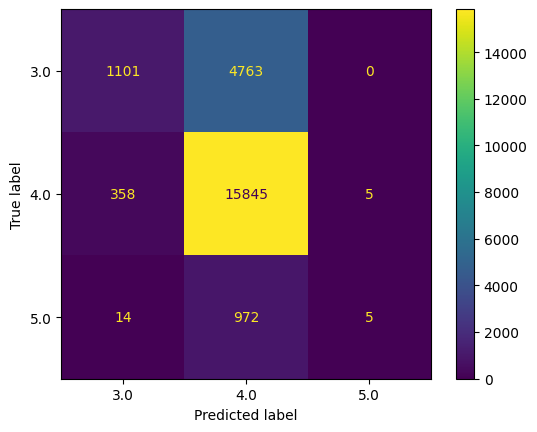

test_3.0_f1-score    0.298316
test_4.0_f1-score    0.838557
test_5.0_f1-score    0.007921
test_accuracy        0.734770
dtype: float64

In [12]:
y_pred, sclf_report = cross_val_report(sclf, X, y)
sclf_report

In [13]:
x2 = SelectKBest(chi2, k='all')
x2.fit(X, y)
pvals = pd.DataFrame(x2.pvalues_, index=x2.feature_names_in_, columns=['p-value'])

x2_features = pvals[pvals['p-value'] < 0.01].index.tolist()
x2_features.remove('PublishDay')

StackingCVClassifier prediction took 129.93107986450195 seconds
   test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0           0.226686           0.833770           0.058252       0.724751
1           0.282018           0.825959           0.125000       0.717815
2           0.201460           0.830850           0.019231       0.719116
3           0.246396           0.823184           0.076190       0.710755
4           0.308448           0.778319           0.074766       0.658283
5           0.198830           0.830673           0.056075       0.718994
6           0.253835           0.833421           0.019802       0.725499
7           0.254980           0.825566           0.076923       0.715525
8           0.237430           0.830785           0.039216       0.721162
9           0.249649           0.831924           0.104348       0.723764


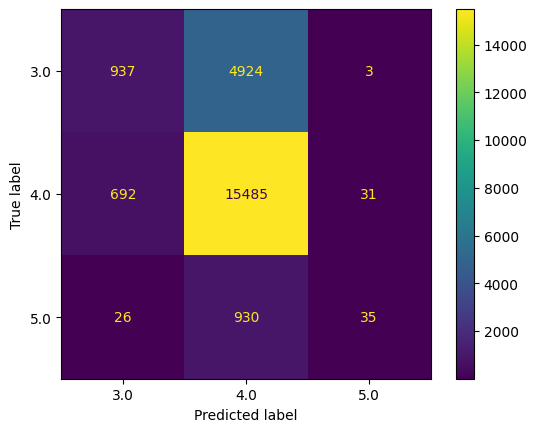

test_3.0_f1-score    0.245973
test_4.0_f1-score    0.824445
test_5.0_f1-score    0.064980
test_accuracy        0.713566
dtype: float64

In [14]:
X_filtered = X[x2_features]
y_pred, sclf_report = cross_val_report(sclf, X_filtered, y)
sclf_report

StackingCVClassifier prediction took 179.37029814720154 seconds
   test_3.0_f1-score  test_4.0_f1-score  test_5.0_f1-score  test_accuracy
0           0.353276           0.781395           0.165289       0.667534
1           0.282443           0.824886           0.000000       0.714781
2           0.201166           0.830624           0.105263       0.719116
3           0.359389           0.769231           0.094340       0.654814
4           0.266129           0.830369           0.000000       0.721162
5           0.201460           0.830890           0.056075       0.719428
6           0.249653           0.831443           0.000000       0.722463
7           0.247253           0.829849           0.057143       0.720295
8           0.227338           0.833333           0.019802       0.724198
9           0.240664           0.829900           0.058252       0.720295


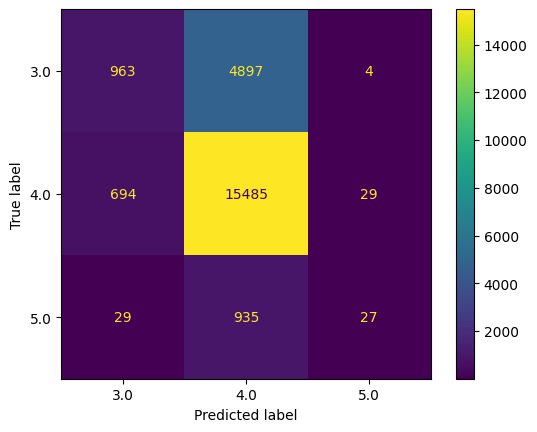

test_3.0_f1-score    0.262877
test_4.0_f1-score    0.819192
test_5.0_f1-score    0.055616
test_accuracy        0.708408
dtype: float64

In [15]:
x2_features += ['PublishDay']
X_filtered = X[x2_features]
y_pred, sclf_report = cross_val_report(sclf, X_filtered, y)
sclf_report